This is the solution for HackerEarth Machine Learning Challenge to predict animal name from images

In [1]:
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization
from keras.models import Model
from PIL import Image
import numpy as np
import os
import pandas as pd

Using TensorFlow backend.


Loading VGG network, without the fully-connect porion of the network. We will make our own FC network that suits our needs.

In [2]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling="max")
#model = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Reading train and test files

In [4]:
train_files = os.listdir("./files/train")
print("Number of training files is: {}".format(len(train_files)))
test_files = os.listdir("./files/test")
print("Number of testing files is: {}".format(len(test_files)))
train_list = pd.read_csv("./files/meta-data/train.csv")
print("Number of unique animals is: {}".format(train_list["Animal"].unique().shape[0]))

Number of training files is: 13000
Number of testing files is: 6000
Number of unique animals is: 30


Plotting a sample image

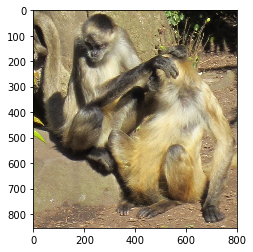

This animal is:
            Image_id         Animal
10851  Img-10852.jpg  spider+monkey


In [5]:
# a sample image
id = 11500
image = plt.imread("./files/train/{}".format(train_files[id]))
plt.imshow(image)
plt.show()
print("This animal is:")
print(train_list[train_list["Image_id"]==train_files[id]])

Converting catogorical to one-hot vector

In [6]:
train_list = pd.get_dummies(train_list, columns=["Animal"])
cols = train_list.columns[1:]

Image preparation for inputing into VGG16 network

In [ ]:
width_avg = 123.68
heiht_avg = 116.779
chanl_avg = 103.939

In [ ]:
X_train = np.zeros([len(train_files), 224, 224, 3])
i = 0
for file in train_files:
    im = Image.open("./files/train/{}".format(file))
    im = im.resize((224,224))
    pix = np.array(im, dtype="float")
    if len(pix.shape)==2:
        pix_2 = np.zeros([pix.shape[0], pix.shape[1], 3])
        pix_2[:,:,0] = pix
        pix_2[:,:,1] = pix
        pix_2[:,:,2] = pix
        pix = pix_2
    pix[:,:,0] -= width_avg
    pix[:,:,1] -= heiht_avg
    pix[:,:,2] -= chanl_avg
    X_train[i,:,:,:] = pix
    i += 1
    if i%1000 == 0:
        print(i)

In [ ]:
X_test = np.zeros([len(test_files), 224, 224, 3])
i = 0
for file in test_files:
    im = Image.open("./files/test/{}".format(file))
    im = im.resize((224,224))
    pix = np.array(im, dtype="float")
    if len(pix.shape)==2:
        pix_2 = np.zeros([pix.shape[0], pix.shape[1], 3])
        pix_2[:,:,0] = pix
        pix_2[:,:,1] = pix
        pix_2[:,:,2] = pix
        pix = pix_2
    pix[:,:,0] -= width_avg
    pix[:,:,1] -= heiht_avg
    pix[:,:,2] -= chanl_avg
    X_test[i,:,:,:] = pix
    i += 1
    if i%1000 == 0:
        print(i)

Creating training output vector

In [7]:
Y_train = np.zeros([len(train_files), len(cols)])
i=0
 
for file in train_files:
    
    Y_train[i,:] = train_list[train_list["Image_id"]==file][cols].values
    i+=1
    

Passing Train and Test inputs through VGG network. The output of this network will be used as the input to a fully-connected network.

In [ ]:
X_train_vgg_output = model.predict(X_train, verbose=1)

In [ ]:
X_test_vgg_output = model.predict(X_test, verbose=1)

In [ ]:
np.save('train_vgg', X_train_vgg_output)
np.save('test_vgg', X_test_vgg_output)

If you have saved the files

In [8]:
X_train_vgg_output = np.load('train_vgg.npy')
X_test_vgg_output = np.load('test_vgg.npy')

In [ ]:
X_train_vgg_output.shape

In [ ]:
X_test_vgg_output.shape

Create FC network

In [9]:
def Model2(input_shape):
    
    X_input = Input(input_shape)
    X = Dense(1000, activation='relu', name='fc')(X_input)
    X = BatchNormalization(axis=-1)(X)
    X = Dense(1000, activation='relu', name='fc2')(X)
    X = BatchNormalization(axis=-1)(X)
    X = Dense(30, activation='softmax', name='output')(X)
    model2 = Model(inputs = X_input, outputs = X, name='AnimalModel')
    
    return model2

In [10]:
AnimalModel = Model2((1,512))

In [11]:
AnimalModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 512)            0         
_________________________________________________________________
fc (Dense)                   (None, 1, 1000)           513000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1000)           4000      
_________________________________________________________________
fc2 (Dense)                  (None, 1, 1000)           1001000   
_________________________________________________________________
output (Dense)               (None, 1, 30)             30030     
Total params: 1,548,030
Trainable params: 1,546,030
Non-trainable params: 2,000
_________________________________________________________________


In [12]:
m = X_train_vgg_output.shape[0]
f = X_train_vgg_output.shape[1]
o = Y_train.shape[1]

# need to reshape input and output for training
X_train_input = np.reshape(X_train_vgg_output, [m, 1, f])

Y_train_output = np.reshape(Y_train, [m, 1, o])

In [13]:
AnimalModel.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
AnimalModel.fit(x = X_train_input, y = Y_train_output, epochs = 4, batch_size = 32)

Epoch 1/4
13000/13000 [==============================] - 8s 598us/step - loss: 0.0501 - acc: 0.9839

predicting the test sets

In [ ]:
m = X_test_vgg_output.shape[0]
f = X_test_vgg_output.shape[1]
# reshape to feed into the network
X_test_input = np.reshape(X_test_vgg_output, [m, 1, f])

In [ ]:
prediction = AnimalModel.predict(X_test_input, verbose=1)

Testing some of the images and predictions

In [ ]:
def one_hot_to_name(input):
    s = ['Animal_antelope', 'Animal_bat', 'Animal_beaver', 'Animal_bobcat',
       'Animal_buffalo', 'Animal_chihuahua', 'Animal_chimpanzee',
       'Animal_collie', 'Animal_dalmatian', 'Animal_german+shepherd',
       'Animal_grizzly+bear', 'Animal_hippopotamus', 'Animal_horse',
       'Animal_killer+whale', 'Animal_mole', 'Animal_moose', 'Animal_mouse',
       'Animal_otter', 'Animal_ox', 'Animal_persian+cat', 'Animal_raccoon',
       'Animal_rat', 'Animal_rhinoceros', 'Animal_seal', 'Animal_siamese+cat',
       'Animal_spider+monkey', 'Animal_squirrel', 'Animal_walrus',
       'Animal_weasel', 'Animal_wolf']
    t = np.argmax(input)
    return s[t]

In [ ]:
one_hot_to_name(prediction[5100,:,:])

In [ ]:
id = 5100
image = plt.imread("./files/test/{}".format(test_files[id]))
plt.imshow(image)
plt.show()


Reshaping predictions back to 2D for creating csv files

In [ ]:
pred_for_submit = np.reshape(prediction, [prediction.shape[0], prediction.shape[2]])

Reading columns of submission file

In [ ]:
submission = pd.read_csv('./files/meta-data/sample_submission.csv')

In [ ]:
def make_submission_file(np_pred, try_no = 1):
    
    """
    np_pred: np array of predicted values (m,30)
    """
    
    submission_pd = pd.DataFrame(columns=submission.columns)
    submission_pd['image_id'] = test_files
    submission_pd.iloc[0:][submission_pd.columns[1:]] = np_pred
    # making fake id column for sorting purposes
    submission_pd["id"] = submission_pd["image_id"].apply(lambda x: int(x.lstrip("Img-").rstrip(".jpg")))
    submission_pd = submission_pd.sort_values(by=["id"])
    # drop id column
    submission_pd = submission_pd.drop(["id"], axis=1)
    # create csv file
    submission_pd.to_csv('./files/meta-data/sbmt{}.csv'.format(try_no), index=False)
    
    return submission_pd

making submission file out of probabilities

In [ ]:
submitted = make_submission_file(pred_for_submit, 6)